# System Identification

## Import libraries

In [3]:
# This ensures all modules are re-imported when import is called. This is useful for easier development and debugging.
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math


In [5]:
import control
from control.matlab import *

In [6]:
from modelling.signal_generation import drbsgen
from modelling.simulation import simulate_first_order_system, simulate_helicrane

## Initialize Real System

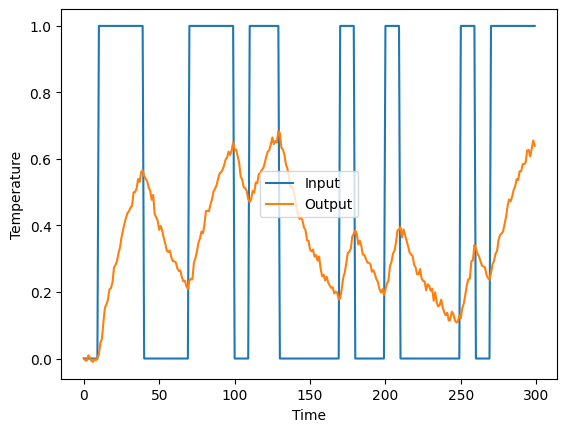

In [24]:
# Model parameters
static_gain = 0.9
time_constant = 30

# Simulation parameters
Ts = 1  # Time between samples
total_time = 300  # Total simulation time

sys = tf(static_gain, [time_constant, 1])


# Generate step input signal
time = np.arange(0, total_time, Ts)
input_signal = np.ones_like(time)*1.0

input_signal, time = drbsgen(1, 1/(time_constant), total_time)
#output_response = static_gain * (1 - np.exp(-time / time_constant))

measurement = simulate_first_order_system(sys, input_signal, time)
measurement["response"] += np.random.normal(0, 0.01, size=time.shape)  # Add some noise


# Plot the input and output data
plt.figure()
plt.plot(time, input_signal, label='Input')
plt.plot(measurement["time"], measurement["response"], label='Output')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


## System Identification

In [25]:

Y_DT = 0
U_DT = 0

U = input_signal[0:]
Y = measurement["response"][0:]

u = U - U_DT
y = Y - Y_DT
N = len(u)

nr_poles = 1
nr_zeros = 1
d = 0 #dead time

# Calculate the regressor matrix
od = max(nr_poles, nr_zeros)
X = np.zeros((N-od-d, nr_poles+nr_zeros))
for i in range(nr_poles):
    X[:, i] = -y[od+d-i-1:N-i-1]
for i in range(nr_zeros):
    X[:, i+nr_poles] = u[od-i-1:N-d-i-1]

Y = y[od+d:]
TH = np.linalg.lstsq(X, Y, rcond=None)[0]


### Transfer Function Analysis

In [26]:
G = control.TransferFunction(TH[nr_poles:], np.concatenate(([1], TH[:nr_poles])), dt=Ts)
G.InputDelay = d
G

TransferFunction(array([0.02893568]), array([ 1.        , -0.96688384]), 1)

In [27]:
dcgain_ident = control.dcgain(G)
poles = G.poles()
print("DC gain = {}".format(dcgain_ident))
print("Discrete poles = {}".format(poles))
cont_poles = ((math.log(poles.real) / Ts))
cont_tau = -1 /(cont_poles)
print("Continuous poles = {}".format(cont_poles))
print("Continuous time constants = {}".format(cont_tau))



DC gain = 0.8737632074582121
Discrete poles = [0.96688384+0.j]
Continuous poles = -0.03367691133186713
Continuous time constants = 29.693934522247577


### Plot System Response

In [28]:
t_test = np.arange(0, total_time, Ts)
u_test = np.ones_like(time)*1.0

In [29]:
ysim = control.forced_response(G, T=t_test, U=input_signal)[1]
yreal = simulate_first_order_system(sys, input_signal, t_test)["response"]


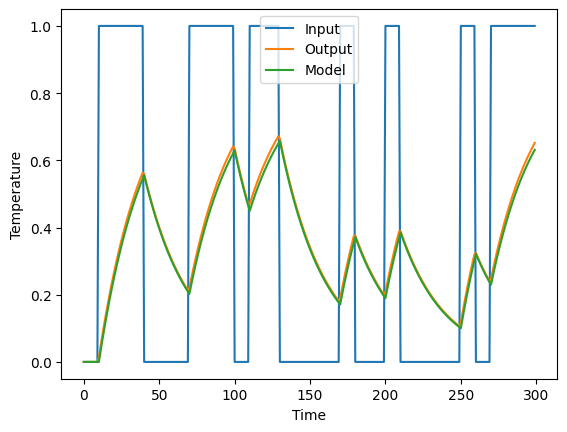

In [30]:
# Plot the input and output data
plt.figure()
plt.plot(t_test, input_signal, label='Input')
plt.plot(t_test, yreal, label='Output')
plt.plot(t_test, ysim, label='Model')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()